## Compound
This notebook explores the metadata and images associated with a set of compounds across all IDR studies.
We aim at finding out the range of concentrations used across studies for each compound.
We retrieve images associated to each of the compound and offer all the other metadata associated with those images as a CSV.  Using a subset of these images, we further programmatically generate an OMERO.figure that can be viewed in any OMERO.server.

### Install dependencies if required
The cell below will install dependencies if you choose to run the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true).

In [ ]:
%pip install idr-py

### Import libraries 

In [2]:
import csv
import os
import pandas as pd
from tempfile import NamedTemporaryFile

import scipy
import numpy
from skimage import filters
import matplotlib.pyplot as plt
from idr import connection

import requests
import json

### Set up where to query and session 

In [3]:
INDEX_PAGE = "https://idr.openmicroscopy.org/webclient/?experimenter=-1"

# create http session
with requests.Session() as session:
    request = requests.Request('GET', INDEX_PAGE)
    prepped = session.prepare_request(request)
    response = session.send(prepped)
    if response.status_code != 200:
        response.raise_for_status()

### Compounds to query 

In [4]:
compounds = ['loratadine', 'cycloheximide', 'ML9', 'ML-9']

### Set up base URLS so can use shorter variable names later on

In [5]:
URL = "https://idr.openmicroscopy.org/mapr/api/{key}/?value={value}&case_sensitive=false&orphaned=true"
SCREENS_PROJECTS_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/?value={value}&case_sensitive=false&id={compound_id}"
PLATES_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/plates/?value={value}&id={screen_id}&case_sensitive=false"
IMAGES_URL = "https://idr.openmicroscopy.org/mapr/api/{key}/images/?value={value}&node={parent_type}&id={parent_id}&case_sensitive=false"
ATTRIBUTES_URL = "https://idr.openmicroscopy.org/webclient/api/annotations/?type=map&image={image_id}"

### Find images for each compound specified
For each compound, search of images in plates then search for annotations associated with the images. The results are saved in a CSV file. 

In [6]:
TYPE = "compound"
KEYS = {TYPE:
    ("InChIKey",
     "PubChem InChIKey",
     "Compound Concentration (microMolar)",
     "Concentration (microMolar)",
     "Dose",
     "Compound MoA",
     "Compound Action")
}

#### Helper method
Parse the output of the json and save it into the CSV file.

In [7]:
def parse_annotation(writer, json_data, name, data_type):
    plate_name = "-"
    screen_name = name
    for p in json_data[data_type]:
        parent_id = p['id']
        plate_name = p['name']
        qs3 = {'key': TYPE, 'value': compound,
                'parent_type': data_type[:-1], 'parent_id': parent_id}
        url3 = IMAGES_URL.format(**qs3)
        c = compound.lower()
        if c.startswith("ml"):
            c = 'ml9'
        for i in session.get(url3).json()['images']:
            image_id = i['id']
            url4 = ATTRIBUTES_URL.format(**{'image_id': image_id})
            row = {}
            inchikey = "unknown"
            concentration = "unknown"
            moa = "unknown"
            for a in session.get(url4).json()['annotations']:
                for v in a['values']:
                    key = str(v[0])
                    if key in KEYS[TYPE]:
                        if key in ['InChIKey', 'PubChem InChIKey']:
                            inchikey = v[1]
                        elif key in ['Dose', 'Compound Concentration (microMolar)', 'Concentration (microMolar)']:
                            concentration = float(v[1].replace(' micromolar', ''))
                        elif key in ['Compound MoA', 'Compound Action']:
                            moa = v[1]
            row.update({'Compound': c,
                        'Screen': screen_name,
                        'Plate': plate_name,
                        'Image': image_id,
                        'InChIKey': inchikey,
                        'Concentration (microMolar)': concentration,
                        'MoA': moa})
            writer.writerow(row)

#### Retrieve data 
A CSV file is first created in the ``home`` directory. The CSV file can then be downloaded to your local machine. To download it, click ``File > Open``, select the CSV file and open it, then click ``File > Download``.

If you are running the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), click on the ``Files`` icon on the left-hand side. The files are saved under the ``root`` directory.  

In [8]:
home = os.path.expanduser("~")
csvfile = NamedTemporaryFile("w", delete=False, newline='', dir=home, suffix=".csv")
try:
    fieldnames = [
        'Compound', 'Screen', 'Plate', 'Image',
        'InChIKey', 'Concentration (microMolar)', 'MoA']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for compound in compounds:
        qs1 = {'key': TYPE, 'value': compound}
        url1 = URL.format(**qs1)
        json_data = session.get(url1).json()
        for m in json_data['maps']:
            qs2 = {'key': TYPE, 'value': compound, 'compound_id': m['id']}
            url2 = SCREENS_PROJECTS_URL.format(**qs2)
            json_data = session.get(url2).json()
            for s in json_data['screens']:
                compound = s['extra']['value']
                qs3 = {'key': TYPE, 'value': compound, 'screen_id': s['id']}
                url3 = PLATES_URL.format(**qs3)
                parse_annotation(writer, session.get(url3).json(), s['name'], 'plates')
finally:
    csvfile.close()

### Explore the data
Read the generated CSV file into a dataframe.

In [9]:
df = pd.read_csv(csvfile.name)
df = df.sort_values(by=['Concentration (microMolar)'])
df

,Compound,Screen,Plate,Image,InChIKey,Concentration (microMolar),MoA
1940,ml9,idr0094-ellinger-sarscov2/screenB (216),ESP0025959,10631902,OZSMSRIUUDGTEP-UHFFFAOYSA-N,0.00636,unknown
2056,ml9,idr0094-ellinger-sarscov2/screenB (216),ESP0025961,10633852,OZSMSRIUUDGTEP-UHFFFAOYSA-N,0.00636,unknown
2007,ml9,idr0094-ellinger-sarscov2/screenB (216),ESP0025960,10633344,OZSMSRIUUDGTEP-UHFFFAOYSA-N,0.00636,unknown
1991,ml9,idr0094-ellinger-sarscov2/screenB (216),ESP0025960,10633350,OZSMSRIUUDGTEP-UHFFFAOYSA-N,0.00636,unknown
2044,ml9,idr0094-ellinger-sarscov2/screenB (216),ESP0025961,10633848,OZSMSRIUUDGTEP-UHFFFAOYSA-N,0.00636,unknown
...,...,...,...,...,...,...,...
1871,ml9,idr0017-breinig-drugscreen/screenA (96),PTEN-/-_LOPAC_Plate_1_Replicate_2,1741163,unknown,unknown,Inhibitor
1872,ml9,idr0017-breinig-drugscreen/screenA (96),PTEN-/-_LOPAC_Plate_1_Replicate_2,1741162,unknown,unknown,Inhibitor
1873,ml9,idr0017-breinig-drugscreen/screenA (96),PTEN-/-_LOPAC_Plate_1_Replicate_2,1741160,unknown,unknown,Inhibitor
1860,ml9,idr0017-breinig-drugscreen/screenA (96),PI3KCA_mt-/wt+_LOPAC_Plate_1_Replicate_1,1752609,unknown,unknown,Inhibitor


## Determine the number of studies
Parse the result returned to determine the number of studies
Names like idrXXX/screenA and idrXXX/screenB are counted as one study.

In [ ]:
curated = {"Screen":[]}
for s in pd.unique(df[["Screen"]].values.ravel()):
    curated["Screen"].append(s.split("/")[0])

df_studies = pd.DataFrame(curated)
studies = pd.unique(df_studies[["Screen"]].values.ravel())
print(len(studies))

In [32]:
from IPython.display import Markdown as md
md("The resuls consists of {} images from {} studies.".format(len(pd.unique(df[["Image"]].values.ravel())), len(studies)))

The resuls consists of 6 studies and 2099 images.

### Plot histogram
Plot the concentration vs the number of images for each compound. 
A png file ``figure.png`` is created in the ``home`` directory. The file can then be downloaded to your local machine. To download it, select the file by ticking the checkbox on the left-hand side of the file. Then click ``Download``.

If you are running the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), click on the ``Files`` icon on the left-hand side. The files are saved under the ``root`` directory. 

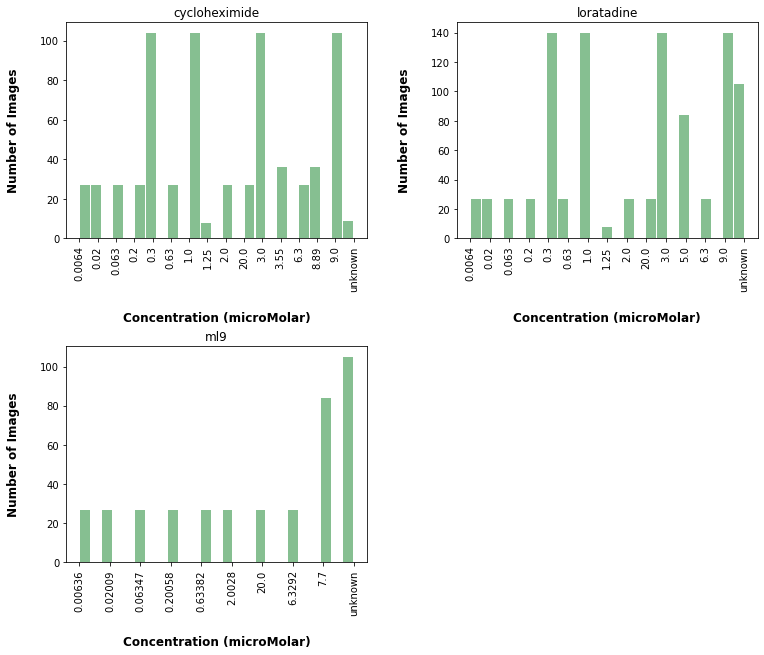

In [9]:
from os.path import expanduser
home = expanduser("~")
ax = df.hist(column='Concentration (microMolar)', by="Compound", bins=25, grid=False, figsize=(12,10), color='#86bf91', zorder=2, rwidth=0.9)
for y in ax:
    for x in y:
        # Set x-axis label
        x.set_xlabel("Concentration (microMolar)", labelpad=20, weight='bold', size=12)

        # Set y-axis label
        x.set_ylabel("Number of Images", labelpad=20, weight='bold', size=12)

plt.savefig(home+'/figure.png')

### Create an OMERO.figure
Create an OMERO.figure programmatically.

## URL to retrieve IDR data 

In [10]:
BASE_URL = "https://idr.openmicroscopy.org/webclient"
IMAGE_DATA_URL = BASE_URL + "/imgData/{id}"

### Helper methods
Methods used to generate the json file, see https://github.com/ome/omero-figure/blob/master/docs/figure_file_format.rst

In [11]:
def get_image_label(value):
    """Display the mean as"""
    value = "%s μM" % "{:.2f}".format(value)
    labels = []
    labels.append({
        "text": value,
        "size": 18,
        "position": "topleft",
        "color": "ff0000"
    })
    return labels


def get_column_label(mean, value):
    """Display the mean as"""
    mean = "mean concentration: %s μM" % "{:.2f}".format(mean)
    labels = []
    labels.append({
        "text": compound.capitalize(),
        "size": 24,
        "position": "top",
        "color": "000000"
    })
    labels.append({
        "text": mean,
        "size": 12,
        "position": "top",
        "color": "000000"
    })
    
    return labels


def get_scalebar_json():
    """Return JSON to add a 10 micron scalebar to bottom-right."""
    return {"show": True,
            "length": 0.5,
            "units": "MILLIMETER",
            "position": "bottomright",
            "color": "FFFFFF",
            "show_label": True,
            "font_size": 10}


def get_panel_json(image, x, y, width, height):
    """Get json for a figure panel."""
    img_json = {
        "imageId": image['id'],
        "y": y,
        "x": x,
        "width": width,
        "height": height,
        "orig_width": image['size']['width'],
        "orig_height": image['size']['height'],
        "sizeT": image['size']['z'],
        "sizeZ": image['size']['t'],
        "channels": image['channels'],
        "name": image['meta']['imageName'],
        "theT": image['rdefs']['defaultT'],
        "theZ": image['rdefs']['defaultZ'],
        "pixel_size_x": image['pixel_size']['x'],
        "pixel_size_y": image['pixel_size']['y'],
        "baseUrl": BASE_URL,
        "labels": [],
    }
    return img_json

In [14]:
def create_column(term, panel_x, panel_y):
    df1 = df[df['Compound'].str.contains(term, na=False, case=False)]
    if len(df1.index) == 0:
        return
    count = 0
    total = 0
    max = float('-inf')
    min = float('inf')
    for row in df1.index:
        concentration = df1['Concentration (microMolar)'][row]
        if concentration != "unknown":
            count = count + 1
            c = float(concentration)
            total = total + c
            if c > max:
                max = c
            if c < min:
                min = c
    panel_y = get_images(max, panel_x, panel_y, df1, compound=term, mean=count/total)
    get_images(min, panel_x, panel_y, df1)
    
    
def get_images(value, panel_x, panel_y, data, compound=None, mean=-1):
    s = str(value)
    df1 = data[data['Concentration (microMolar)'] == s]
    rows = 0
    for row in df1.index:
        image_id = df1['Image'][row]
        if rows < 2:
            qs = {'id': image_id}
            url = IMAGE_DATA_URL.format(**qs)
            image_data = session.get(url).json()
            j = get_panel_json(image_data, panel_x, panel_y,
                               panel_width, panel_height)
            j['labels'].extend(get_image_label(value))
            if rows == 0 and compound is not None:
                j['labels'].extend(get_column_label(mean, compound))
            panels_json.append(j)
            panels_json[-1]['scalebar'] = get_scalebar_json()
        else:
            break
        rows = rows + 1
        panel_y += panel_height + spacing
    return panel_y          

### Create the figure 

In [15]:
figure_json = {"version": 5}
panel_width = 150
panel_height = panel_width
spacing = panel_width/5
margin = 40

panels_json = []
panel_x = margin
panel_y = 2*margin
for compound in compounds:
    create_column(compound.lower(), panel_x, panel_y)
    panel_x += panel_width + spacing
    panel_y = 2*margin

figure_json['panels'] = panels_json
figure_json["figureName"] = "Compounds Concentration"

### Save the figure as a json file
You can then download the ``.json`` file, by clicking ``File > Open``, selecting it and cliking ``File > Download``. 

If you are running the notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), click on the ``Files`` icon on the left-hand side. The files are saved under the ``root`` directory. 

Alternatively, you can copy the content of the ``json`` file directly from this notebook UI. In OMERO.figure use ``File>Import from JSON...``.

In [16]:
with open(home+'/figure.json', 'w', encoding='utf-8') as f:
    json.dump(figure_json, f, ensure_ascii=False, indent=4)

### Generated OMERO.figure
![OMERO.figure](images/compound_figure.png)

### License (BSD 2-Clause)

Copyright (C) 2021 University of Dundee. All Rights Reserved.

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution. THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.